# Reptile을 사용한 퓨샷 학습

**Author:** [ADMoreau](https://github.com/ADMoreau)<br>
**Date created:** 2020/05/21<br>
**Last modified:** 2020/05/30<br>
**Description:** Reptile을 사용한 Omniglot 데이터 세트의 Few-shot 분류.

## 소개

Reptile 알고리즘 은 모델 불가지론적 메타 학습을 수행하기 위해 OpenAI에 의해 개발되었습니다. 특히 이 알고리즘은 최소한의 교육(퓨샷 학습)으로 새로운 작업을 수행하는 방법을 빠르게 학습하도록 설계되었습니다. 이 알고리즘은 이전에 본 적이 없는 데이터의 미니 배치에서 훈련된 가중치와 고정된 메타 반복 횟수에 대한 훈련 이전의 모델 가중치 간의 차이를 사용하여 확률적 경사 하강법을 수행하여 작동합니다.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

## Hyperparameters 정의

In [10]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

## 데이터 준비

[Omniglot 데이터셋](https://github.com/brendenlake/omniglot/) 은 50개의 다른 알파벳에서 가져온 1,623개의 문자로 구성된 데이터셋이며 각 문자에 대한 20개의 예가 있습니다. 각 캐릭터에 대한 20개의 샘플은 Amazon의 Mechanical Turk를 통해 온라인으로 그려졌습니다. 퓨어샷 학습 작업의 경우 k샘플(또는 "샷")이 n무작위로 선택된 클래스에서 무작위로 추출됩니다. 이 n숫자 값은 몇 가지 예가 주어진 새 작업을 학습하는 모델의 능력을 테스트하는 데 사용할 임시 레이블의 새 세트를 만드는 데 사용됩니다. 다시 말해서, 5개의 클래스에 대해 교육하는 경우 새 클래스 레이블은 0, 1, 2, 3 또는 4가 됩니다. Omniglot은 가져올 클래스가 많기 때문에 이 작업에 대한 훌륭한 데이터세트입니다. 각 클래스에 대한 적절한 수의 샘플.


### 주의 사항 

windows의 경우 파일 경로의 길이 제한 문제 발생 시 아래와 같이 조치 :

명령창에서  
regedit를 실행 ( 레지스트리 설정 )

HKEY_LOCAL_MACHINE\SYSTEM\CurrentControlSet\Control\FileSystem 경로에서 
LongPathsEnabled 설정을 1을 바꿈

파워쉘에서 주피터 노트북을 새로 실행 해야 함

In [90]:
class Dataset:
    # 이 클래스는 few-shot dataset 생성을 용이하게 합니다.
    # 빠르게 샘플링할 수 있는 Omniglot 데이터 세트에서 
    # 동시에 새 레이블을 생성할 수 있습니다.
    def __init__(self, training):
        # Omniglot 데이터가 포함된 tfrecord 파일을 다운로드하고 데이터세트로 변환합니다.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # 데이터 세트를 반복하여 각 개별 이미지와 해당 클래스를 
        # 가져오고 해당 데이터를 사전에 넣습니다.
        self.data = {}

        def extraction(image, label):
            # 이 기능은 Omniglot 이미지를 원하는 크기로 축소하고,
            # 픽셀 값을 조정하고 RGB 이미지를 회색조로 변환 합니다.
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
#         print(temp_labels.shape)
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
#         print(temp_images.shape)
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # 전체 레이블 집합에서 레이블의 임의 하위 집합을 가져옵니다.
#         print(len(self.labels))
        label_subset = random.choices(self.labels, k=num_classes)
#         print(label_subset)
        for class_idx, class_obj in enumerate(label_subset):
            # few-shot 학습에서 미니 배치에 대한 임시 레이블로 열거된 인덱스 값을 사용합니다.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
#             print(temp_labels)
            # 테스트를 위해 분할 데이터 세트를 생성하는 경우 각 레이블에서 
            # 추가 샘플을 선택하여 테스트 데이터 세트를 생성합니다.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # 임의로 선택한 label_subset의 각 인덱스에 대해 
                # 필요한 수의 이미지를 샘플링합니다.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # 다운로드 중에 발생할 수 있는 SSL 경고를 비활성화합니다.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

## 데이터세트의 몇 가지 예 시각화

In [30]:
a = np.arange(28*28).reshape(28,28)
print(a.shape)
# print((a,))
# print((a,)*3)
print(a)
temp = np.stack((a,) * 3, axis=2)
print(temp.shape)
print(temp)

(28, 28)
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27]
 [ 28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
   46  47  48  49  50  51  52  53  54  55]
 [ 56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
   74  75  76  77  78  79  80  81  82  83]
 [ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
  102 103 104 105 106 107 108 109 110 111]
 [112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
  130 131 132 133 134 135 136 137 138 139]
 [140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
  158 159 160 161 162 163 164 165 166 167]
 [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
  186 187 188 189 190 191 192 193 194 195]
 [196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
  214 215 216 217 218 219 220 221 222 223]
 [224 225 226 227 228 229 230 231 232 233 234 235 236 2

964


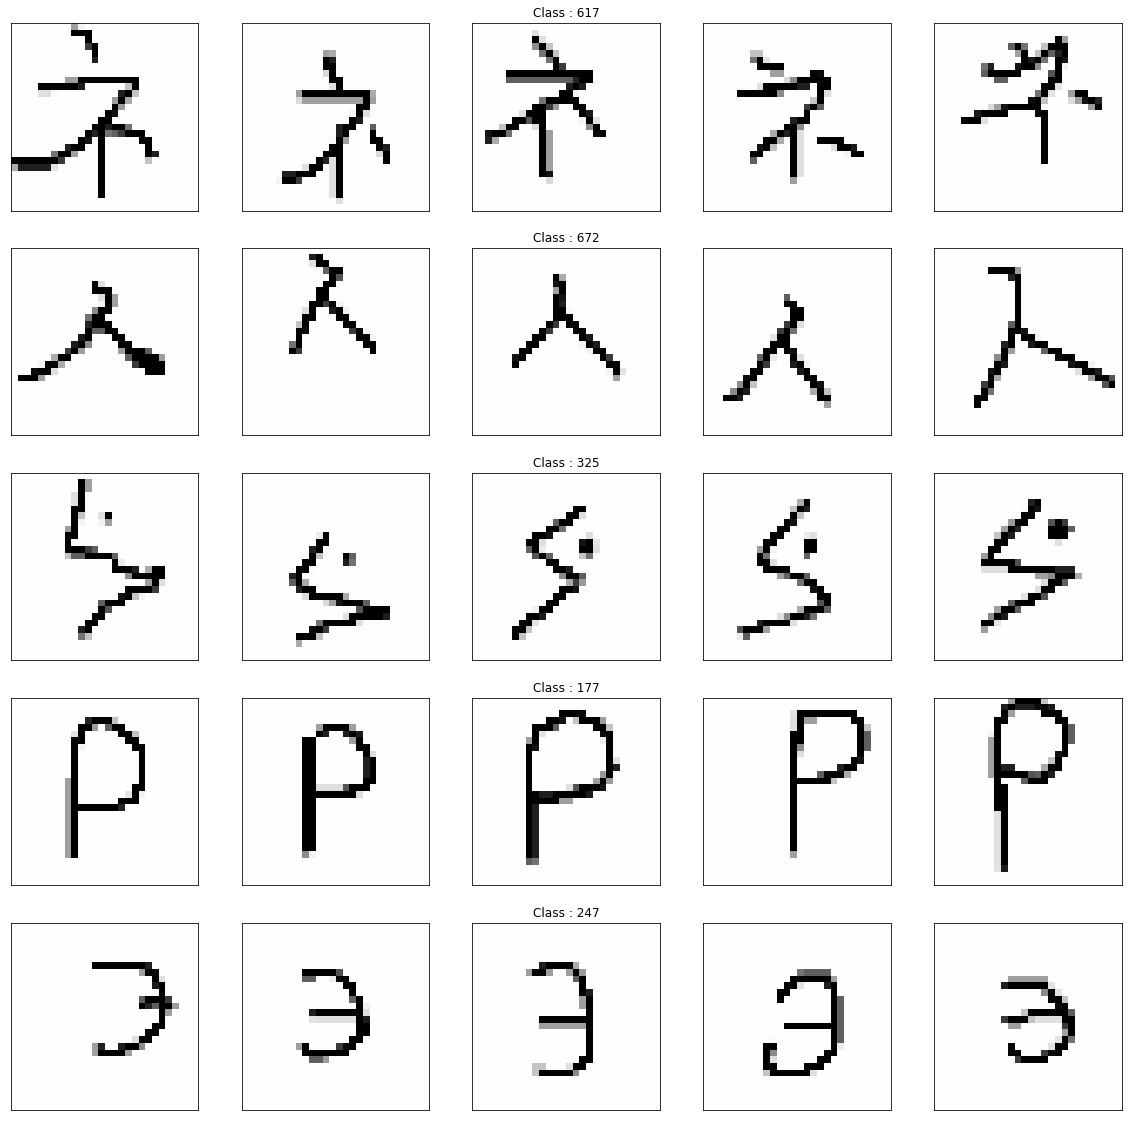

In [39]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())
print(len(sample_keys))

for a in range(5):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
#         print(temp_image.shape)
#         print(temp_image[:, :, 0].shape)
#         print(type((temp_image[:, :, 0],)))
#         print(len((temp_image[:, :, 0],)))
#         print(type((temp_image[:, :, 0],)*3))
#         print(len((temp_image[:, :, 0],)*3))

        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
#         print(temp_image.shape)
#         print(temp_image[0,0,:])
        
        temp_image *= 255
#         print(temp_image[0,0,:])
        
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])

        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
#     break
plt.show()


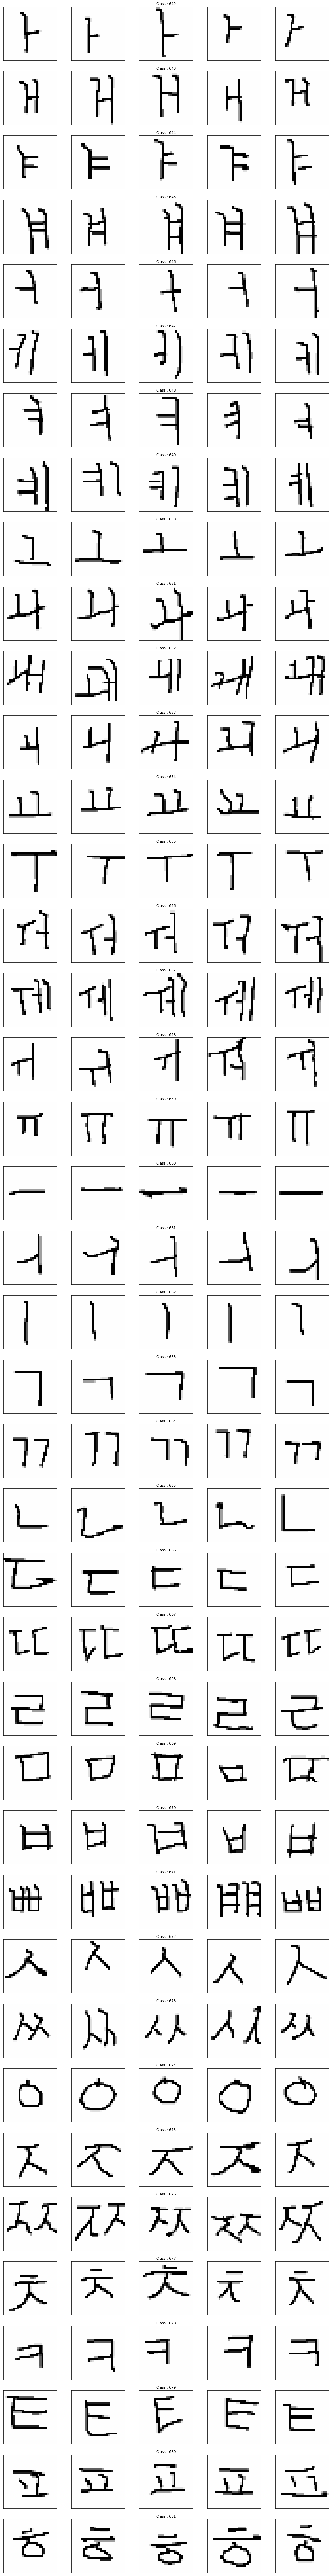

In [55]:
_, axarr = plt.subplots(nrows=40, ncols=5, figsize=(20, 160))

for a in range(40):
    for b in range(5):
        temp_image = train_dataset.data[str(a+642)][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
       
        temp_image *= 255
        
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + str(a+642))

        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

## 모델 구축


In [67]:

def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)  # (None,28,28,1)(3,3,1,64)
x = conv_bn(x)       # (None,14,14,64)(3,3,64,64)
x = conv_bn(x)       # (None,7,7,64)(3,3,64,64)
x = conv_bn(x)       # (None,4,4,64)(3,3,64,64)
x = layers.Flatten()(x)  # (None,2,2,64)  => (None,64)
outputs = layers.Dense(classes, activation="softmax")(x)  # (None,256)(256,5) => (None,5)
model = keras.Model(inputs=inputs, outputs=outputs)
# model.summary()
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)


## 모델 훈련


In [89]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # 모델에서 임시로 가중치를 저장합니다.
    old_vars = model.get_weights()
    # 전체 데이터세트에서 샘플을 가져옵니다.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    
#     i=0
#     for images, labels in mini_dataset:
#         i+=1
#         print(images.shape, i)
#     break
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
#         print(len(grads))
    new_vars = model.get_weights()
    # 메타 단계에 대해 SGD를 수행합니다.
    for var in range(len(new_vars)):
#         print(new_vars[var].shape)
#         print('before=', new_vars[var])
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
#         print('cur_meta_step_size=', cur_meta_step_size)
#         print('after =', new_vars[var])
    # 메타 학습 단계 후에 새로 훈련된 가중치를 모델에 다시 로드합니다.
    model.set_weights(new_vars)
    # 평가 루프
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # 전체 데이터세트에서 미니 데이터세트를 샘플링합니다.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # 평가 정확도를 얻은 후 가중치를 재설정합니다.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )


(100,)
(100, 28, 28, 1)
964
['719', '177', '724', '171', '409']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.

## 결과 시각화


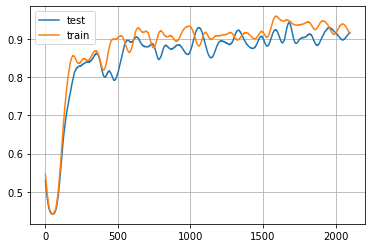

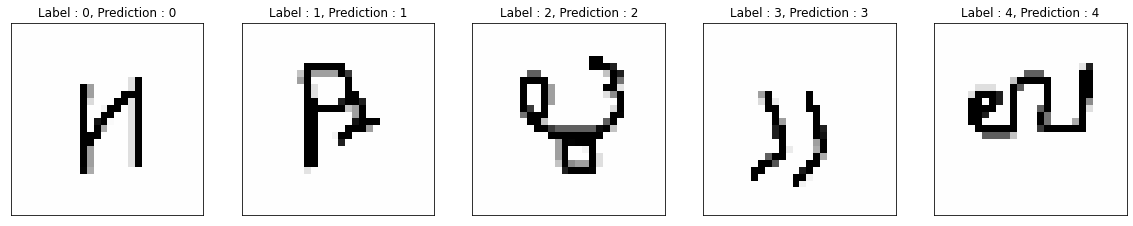

In [69]:
# 첫째, 표시를 위해 훈련 및 테스트 배열을 매끄럽게 하기 위한 일부 전처리입니다.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# 훈련 정확도를 표시합니다.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()


In [70]:
model.save_weights('weights.h5')